
Batch Size Experiment: 1
Epoch 1/100, Validation Accuracy: 0.6140
Epoch 2/100, Validation Accuracy: 0.6727
Epoch 3/100, Validation Accuracy: 0.7033
Epoch 4/100, Validation Accuracy: 0.7182
Epoch 5/100, Validation Accuracy: 0.7325
Epoch 6/100, Validation Accuracy: 0.7424
Epoch 7/100, Validation Accuracy: 0.7477
Epoch 8/100, Validation Accuracy: 0.7557
Epoch 9/100, Validation Accuracy: 0.7606
Epoch 10/100, Validation Accuracy: 0.7648
Epoch 11/100, Validation Accuracy: 0.7691
Epoch 12/100, Validation Accuracy: 0.7691
Epoch 13/100, Validation Accuracy: 0.7737
Epoch 14/100, Validation Accuracy: 0.7785
Epoch 15/100, Validation Accuracy: 0.7769
Epoch 16/100, Validation Accuracy: 0.7810
Epoch 17/100, Validation Accuracy: 0.7797
Epoch 18/100, Validation Accuracy: 0.7855
Epoch 19/100, Validation Accuracy: 0.7844
Epoch 20/100, Validation Accuracy: 0.7856
Epoch 21/100, Validation Accuracy: 0.7884
Epoch 22/100, Validation Accuracy: 0.7891
Epoch 23/100, Validation Accuracy: 0.7927
Epoch 24/100, Val

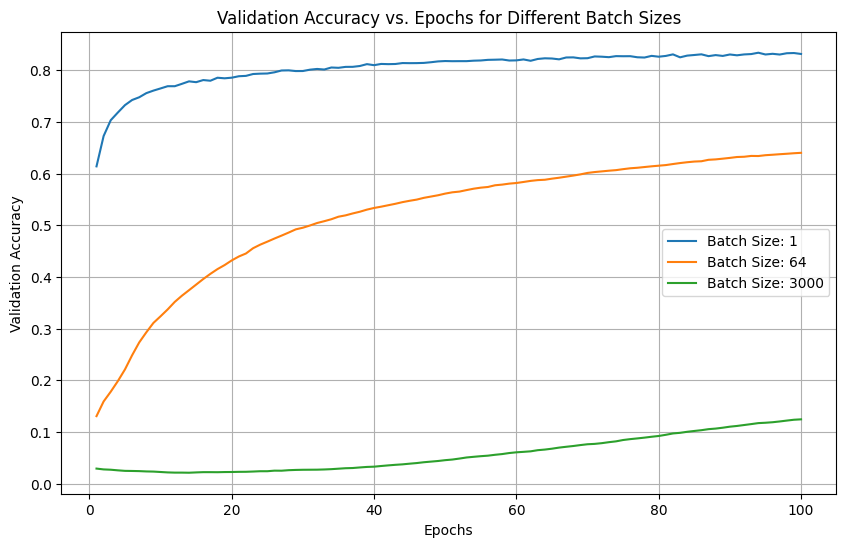

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function for one-hot encoding
def encode_one_hot(labels):
    num_samples = labels.shape[0]
    num_classes = 10  # Assuming 10 classes (0-9)
    encoded = np.zeros((num_samples, num_classes), dtype=int)
    encoded[np.arange(num_samples), labels] = 1
    return encoded

# Function to read pixel data
def load_pixel_data(file_path):
    with open(file_path, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8, offset=16)
    return data.reshape(-1, 784).astype('float32') / 255.0

# Function to read label data
def load_label_data(file_path):
    with open(file_path, 'rb') as f:
        labels = np.frombuffer(f.read(), dtype=np.uint8, offset=8)
    return encode_one_hot(labels)

# Function to load MNIST dataset
def load_data(base_path):
    X_train = load_pixel_data(os.path.join(base_path, "train-images-idx3-ubyte"))
    y_train = load_label_data(os.path.join(base_path, "train-labels-idx1-ubyte"))
    X_test = load_pixel_data(os.path.join(base_path, "t10k-images-idx3-ubyte"))
    y_test = load_label_data(os.path.join(base_path, "t10k-labels-idx1-ubyte"))
    return X_train, y_train, X_test, y_test

# Logistic Regression Model
class LogisticModel:
    def __init__(self, lr=1e-3, reg=1e-4, num_epochs=100, batch=200, input_size=784, num_classes=10):
        self.lr = lr
        self.reg = reg
        self.epochs = num_epochs
        self.batch_size = batch
        self.weights = np.random.randn(input_size, num_classes)
        self.biases = np.zeros((1, num_classes))

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def train(self, X_train, y_train, X_val, y_val):
        num_samples = X_train.shape[0]
        accuracies = []
        for epoch in range(self.epochs):
            indices = np.random.permutation(num_samples)
            X_train, y_train = X_train[indices], y_train[indices]

            for start in range(0, num_samples, self.batch_size):
                end = start + self.batch_size
                X_batch, y_batch = X_train[start:end], y_train[start:end]

                # Forward pass
                logits = np.dot(X_batch, self.weights) + self.biases
                predictions = self.softmax(logits)

                # Gradients
                error = predictions - y_batch
                grad_weights = np.dot(X_batch.T, error) / self.batch_size + self.reg * self.weights
                grad_biases = np.sum(error, axis=0, keepdims=True) / self.batch_size

                # Update weights and biases
                self.weights -= self.lr * grad_weights
                self.biases -= self.lr * grad_biases

            val_accuracy, _ = self.evaluate(X_val, y_val)
            accuracies.append(val_accuracy)
            print(f"Epoch {epoch + 1}/{self.epochs}, Validation Accuracy: {val_accuracy:.4f}")
        return accuracies

    def predict(self, X):
        logits = np.dot(X, self.weights) + self.biases
        return np.argmax(self.softmax(logits), axis=1)

    def evaluate(self, X, y_true):
        y_pred = self.predict(X)
        y_true_labels = np.argmax(y_true, axis=1)
        accuracy = np.mean(y_true_labels == y_pred)
        return accuracy, self.conf_matrix(y_true_labels, y_pred)

    @staticmethod
    def conf_matrix(y_true, y_pred):
        num_classes = np.max(y_true) + 1
        cm = np.zeros((num_classes, num_classes), dtype=int)
        for true_label, pred_label in zip(y_true, y_pred):
            cm[true_label, pred_label] += 1
        return cm

# Plot accuracy for different batch sizes
def plot_accuracies(batch_results):
    plt.figure(figsize=(10, 6))
    for batch_size, accuracies in batch_results.items():
        plt.plot(range(1, len(accuracies) + 1), accuracies, label=f"Batch Size: {batch_size}")
    plt.title("Validation Accuracy vs. Epochs for Different Batch Sizes")
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

# Experiment with batch sizes
def batch_size_experiment(X_train, y_train, X_val, y_val, params):
    batch_sizes = [1, 64, 3000]
    results = {}
    for batch in batch_sizes:
        print(f"\nBatch Size Experiment: {batch}")
        model = LogisticModel(batch=batch, **params)
        results[batch] = model.train(X_train, y_train, X_val, y_val)
    plot_accuracies(results)

# Main function to run experiments
def main():
    dataset_path = "/Users/elifsorguc/Desktop/Bilkent/ML/MachineLearning-PCA-LogReg/data/mnist"
    X_train, y_train, X_test, y_test = load_data(dataset_path)
    X_val, y_val = X_train[:10000], y_train[:10000]
    X_train, y_train = X_train[10000:], y_train[10000:]

    params = {
        'lr': 5e-4,
        'reg': 1e-4,
        'num_epochs': 100,
        'input_size': 784,
        'num_classes': 10
    }

    batch_size_experiment(X_train, y_train, X_val, y_val, params)

if __name__ == "__main__":
    main()
